In [81]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [82]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

# Plan of Action

### For X set

Add column for location, and if it is estimated data. Add them sequentially under eachother

### For Y set
Sequentially under eacherother. Normalize. Must be able to denormalize. NaN values? Use A's values.

Fixing the y-set first

In [83]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

intervals = find_repeated_rows(train_b)
print("The largest interval is", intervals[0])

The largest interval is (13409, 14466)


In [84]:
all_y = [train_a, train_b, train_c]
labels = ['A', 'B', 'C']

table = {}

i = 0
for y in all_y:
    loc, intervals = labels[i], find_repeated_rows(y)
    if isinstance(intervals[0], (int, float)):
        intervals = np.asarray(intervals, dtype=float)
    intervals = list(intervals) + [np.nan] * (1421 - len(intervals))
    table[loc] = intervals
    print("The largest interval for", loc, intervals[0])
    i += 1

table = pd.DataFrame(table)
table.head()

The largest interval for A (5176, 5218)
The largest interval for B (13409, 14466)
The largest interval for C (18105, 18727)


,A,B,C
0,"(5176, 5218)","(13409, 14466)","(18105, 18727)"
1,"(4526, 4547)","(19138, 20141)","(26048, 26669)"
2,"(22429, 22450)","(18690, 19137)","(27224, 27748)"
3,"(22933, 22954)","(10966, 11307)","(25400, 25876)"
4,"(67, 87)","(26115, 26353)","(10047, 10375)"


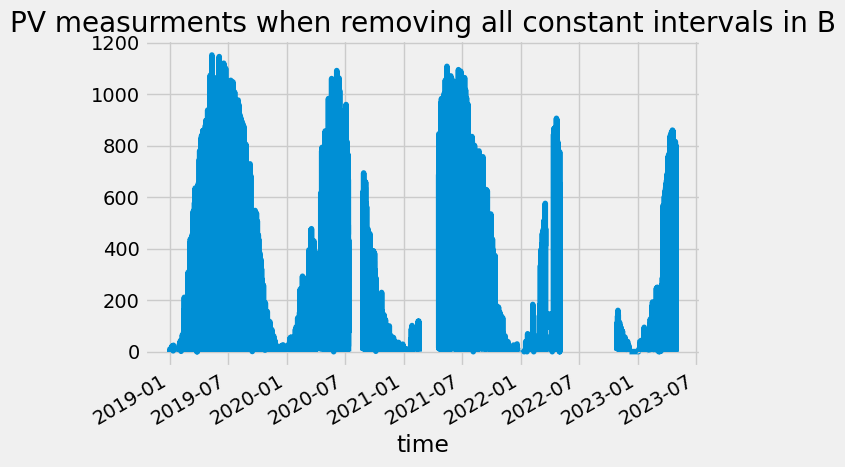

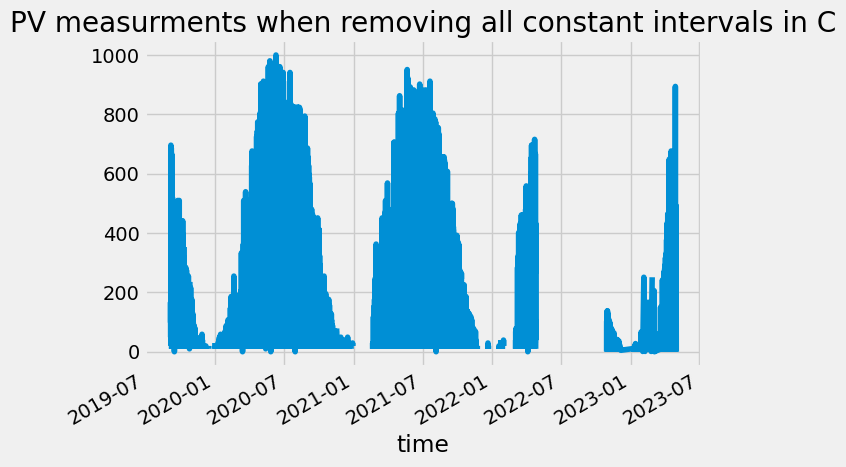

In [85]:
i = 1
for y in all_y[1:]:
    loc, intervals = labels[i], find_repeated_rows(y)
    for start, end in intervals:
        for row_index in range(start, end + 1):
            y.at[row_index, 'pv_measurement'] = np.nan

    test = y.set_index('time')
    test['pv_measurement'].plot(title="PV measurments when removing all constant intervals in " + loc)
    plt.show()
    i += 1

In [86]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

In [87]:
'''
full_date_range = pd.date_range(start=train_b.index.min(), end=train_b.index.max(), freq='H')
missing_dates = full_date_range.difference(train_b.index)
missing_df = pd.DataFrame(index=missing_dates)
train_b = pd.concat([train_b, missing_df]).sort_index()

full_date_range = pd.date_range(start=train_c.index.min(), end=train_c.index.max(), freq='H')
missing_dates = full_date_range.difference(train_c.index)
missing_df = pd.DataFrame(index=missing_dates)
train_c = pd.concat([train_c, missing_df]).sort_index()
'''


"\nfull_date_range = pd.date_range(start=train_b.index.min(), end=train_b.index.max(), freq='H')\nmissing_dates = full_date_range.difference(train_b.index)\nmissing_df = pd.DataFrame(index=missing_dates)\ntrain_b = pd.concat([train_b, missing_df]).sort_index()\n\nfull_date_range = pd.date_range(start=train_c.index.min(), end=train_c.index.max(), freq='H')\nmissing_dates = full_date_range.difference(train_c.index)\nmissing_df = pd.DataFrame(index=missing_dates)\ntrain_c = pd.concat([train_c, missing_df]).sort_index()\n"

In [88]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

Min-max scaling

In [89]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

### Patching these gap intervals with corresponding values from location A

In [90]:
'''
train_b['pv_measurement'] = train_b['pv_measurement'].combine_first(train_a['pv_measurement'])
train_c['pv_measurement'] = train_c['pv_measurement'].combine_first(train_a['pv_measurement'])
train_b['pv_measurement'].plot(title="B and C after correcting for gaps", label = 'B')
train_c['pv_measurement'].plot(label = 'C')
plt.legend()
plt.show()
'''

'\ntrain_b[\'pv_measurement\'] = train_b[\'pv_measurement\'].combine_first(train_a[\'pv_measurement\'])\ntrain_c[\'pv_measurement\'] = train_c[\'pv_measurement\'].combine_first(train_a[\'pv_measurement\'])\ntrain_b[\'pv_measurement\'].plot(title="B and C after correcting for gaps", label = \'B\')\ntrain_c[\'pv_measurement\'].plot(label = \'C\')\nplt.legend()\nplt.show()\n'

In [91]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [92]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


### Fixing the X set

### Fixing the time gap in features 

The plan is to map A's features on rows that are NaN on B and C. The correlation beteen the features from the different locations are very high as seen in the eda_1 notebook.

In [93]:
all_x_train = [X_train_observed_a, X_train_estimated_a, X_train_observed_b, 
                     X_train_estimated_b, X_train_observed_c, X_train_estimated_c]

In [94]:
for i in range(len(all_x_train)):
    all_x_train[i]['date_forecast'] = pd.to_datetime(all_x_train[i]['date_forecast'])
    all_x_train[i].set_index('date_forecast', inplace=True)
    if "date_calc" in all_x_train[i]:
        all_x_train[i].drop("date_calc", axis=1, inplace=True)

In [95]:
def concat_datasets(df1, df2):
    x = pd.concat([df1, df2], ignore_index=False)
    return x

def add_missing_dates(df):
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    df = pd.concat([df, missing_df]).sort_index()
    return df

def combine_with_a(df):
    return df.combine_first(X_train_observed_a)

def fix_dataset(obs, est):
    x = concat_datasets(obs, est)
    x = add_missing_dates(x)
    x = x.combine_first(X_train_observed_a)
    return x

In [96]:
'''
x_b = fix_dataset(X_train_observed_b, X_train_estimated_b)
x_c = fix_dataset(X_train_observed_c, X_train_estimated_c)

all_x_train = [X_train_observed_a, X_train_estimated_a, x_b, x_c]
'''


'\nx_b = fix_dataset(X_train_observed_b, X_train_estimated_b)\nx_c = fix_dataset(X_train_observed_c, X_train_estimated_c)\n\nall_x_train = [X_train_observed_a, X_train_estimated_a, x_b, x_c]\n'

### Aggregating the rows for every hour

In [97]:
for i in range(len(all_x_train)):
    all_x_train[i] = all_x_train[i].resample('60min').sum()

X_train_observed_a, X_train_estimated_a, X_train_observed_b, X_train_estimated_b, X_train_observed_c, X_train_estimated_c = all_x_train

In [98]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location'] = 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location'] = 'C', 'C'
#x_b['location'] = 'B'
#x_c['location'] = 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1
#x_b['estimated'], x_b.loc[x_b.index > X_train_estimated_b.index.min(), 'estimated'] = 0, 1
#x_c['estimated'], x_c.loc[x_c.index > X_train_estimated_c.index.min(), 'estimated'] = 0, 1

In [99]:
X = pd.concat(all_x_train, ignore_index=False)
X = X.sort_index()

# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

print('Shape of X:', X.shape)
X.head()

Shape of X: (101362, 49)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,location_A,location_B,location_C
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,21.900000,4.963,4520.100098,0.0,0.0,4520.100098,4.0,1099.900024,0.0,0.0,...,335.299988,66037.000000,11.6,4.5,10.500000,0.0,0,0,0,1
2019-01-01 00:00:00,22.100000,4.959,4802.700195,0.0,0.0,4802.700195,0.0,1100.599976,0.0,0.0,...,345.299988,67311.203125,11.2,4.7,10.200001,0.0,0,0,1,0
2019-01-01 01:00:00,21.400002,4.960,4266.699707,0.0,0.0,4266.699707,3.0,1098.599976,0.0,0.0,...,396.299988,53110.101562,14.6,5.7,13.400000,0.0,0,0,0,1
2019-01-01 01:00:00,21.700001,4.959,4525.699707,0.0,0.0,4525.699707,0.0,1099.300049,0.0,0.0,...,396.299988,51109.796875,14.2,6.1,12.800000,0.0,0,0,1,0
2019-01-01 02:00:00,21.600000,4.954,4244.000000,0.0,0.0,4244.000000,0.0,1099.199951,0.0,0.0,...,391.700012,44562.000000,16.1,8.6,13.700000,0.0,0,0,1,0


If you want to search for rows on a spesific date

In [100]:
X.loc['2022-11-08 12:00']

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,location_A,location_B,location_C
date_forecast,,,,,,,,,,,,,,,,,,,,,
2022-11-08 12:00:00,24.0,4.973,0.0,1562409.25,377.299988,0.0,0.0,1105.900024,144.800003,555930.3125,...,8.9,194941.09375,14.6,-14.0,-3.8,0.0,1,1,0,0
2022-11-08 12:00:00,24.0,4.980,0.0,1562301.75,377.200012,0.0,0.0,1105.900024,144.800003,555822.0000,...,8.9,190073.90625,14.6,-14.0,-3.8,0.0,1,0,1,0
2022-11-08 12:00:00,24.0,4.968,0.0,1571856.50,379.799988,0.0,0.0,1105.199951,144.899994,557198.3125,...,10.9,192327.59375,10.8,-10.8,-0.2,0.0,1,0,0,1


In [101]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,22.100000,4.959,4802.700195,0.0,0.0,4802.700195,...,-193.277008,0.0,1113.000000,345.299988,67311.203125,11.2,4.7,10.200001,0.0,0
2019-01-01 00:00:00,NaN,0,0,1,21.900000,4.963,4520.100098,0.0,0.0,4520.100098,...,-193.423996,0.0,1113.400024,335.299988,66037.000000,11.6,4.5,10.500000,0.0,0
2019-01-01 01:00:00,NaN,0,0,1,21.400002,4.960,4266.699707,0.0,0.0,4266.699707,...,-179.802002,0.0,1112.800049,396.299988,53110.101562,14.6,5.7,13.400000,0.0,0
2019-01-01 01:00:00,NaN,0,1,0,21.700001,4.959,4525.699707,0.0,0.0,4525.699707,...,-179.679001,0.0,1112.300049,396.299988,51109.796875,14.2,6.1,12.800000,0.0,0
2019-01-01 02:00:00,NaN,0,1,0,21.600000,4.954,4244.000000,0.0,0.0,4244.000000,...,-159.455994,0.4,1112.199951,391.700012,44562.000000,16.1,8.6,13.700000,0.0,0


Check a single date in the entire dataframe.

In [102]:
df.loc['2019-01-01 10:00:00']

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 10:00:00,NaN,0,0,1,22.699999,5.000,6908.000000,182061.90625,82.500000,6908.000000,...,10.865,2.0,1108.599976,400.0,14441.400391,28.000000,20.799999,-18.799999,0.4,0
2019-01-01 10:00:00,0.000749,0,1,0,22.799999,5.002,7424.700195,178143.09375,81.300003,7424.700195,...,10.716,1.6,1109.400024,400.0,15510.099609,29.200001,22.000000,-19.200001,0.0,0


In [103]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [104]:
df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,...,wind_speed_w_1000hPa:ms,estimated,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,0,1,0,22.100000,4.959,4802.700195,0.0,0.0,4802.700195,...,0.0,0,0,1,1,1,2019,1,1,1
2019-01-01 00:00:00,NaN,0,0,1,21.900000,4.963,4520.100098,0.0,0.0,4520.100098,...,0.0,0,0,1,1,1,2019,1,1,1
2019-01-01 01:00:00,NaN,0,0,1,21.400002,4.960,4266.699707,0.0,0.0,4266.699707,...,0.0,0,1,1,1,1,2019,1,1,1
2019-01-01 01:00:00,NaN,0,1,0,21.700001,4.959,4525.699707,0.0,0.0,4525.699707,...,0.0,0,1,1,1,1,2019,1,1,1
2019-01-01 02:00:00,NaN,0,1,0,21.600000,4.954,4244.000000,0.0,0.0,4244.000000,...,0.0,0,2,1,1,1,2019,1,1,1


### Choosing features

In [105]:
FEATURES = [
    'direct_rad_1h:J', 'effective_cloud_cover:p', 'clear_sky_energy_1h:J',
    'visibility:m', 'sun_elevation:d', 'is_day:idx', 'clear_sky_rad:W',
    'is_in_shadow:idx', 'sun_azimuth:d',
    'hour', 'dayofweek', 'quarter', 'month', 
    'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'location_A', 'location_B', 'location_C', 
    'estimated'
]

TARGET = 'pv_measurement'

In [106]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [107]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

direct_rad_1h:J                0
effective_cloud_cover:p        0
clear_sky_energy_1h:J          0
visibility:m                   0
sun_elevation:d                0
is_day:idx                     0
clear_sky_rad:W                0
is_in_shadow:idx               0
sun_azimuth:d                  0
hour                           0
dayofweek                      0
quarter                        0
month                          0
year                           0
dayofyear                      0
dayofmonth                     0
weekofyear                     0
location_A                     0
location_B                     0
location_C                     0
estimated                      0
pv_measurement             43484
dtype: int64
direct_rad_1h:J            0
effective_cloud_cover:p    0
clear_sky_energy_1h:J      0
visibility:m               0
sun_elevation:d            0
is_day:idx                 0
clear_sky_rad:W            0
is_in_shadow:idx           0
sun_azimuth:d              0


In [108]:
df = df.dropna()

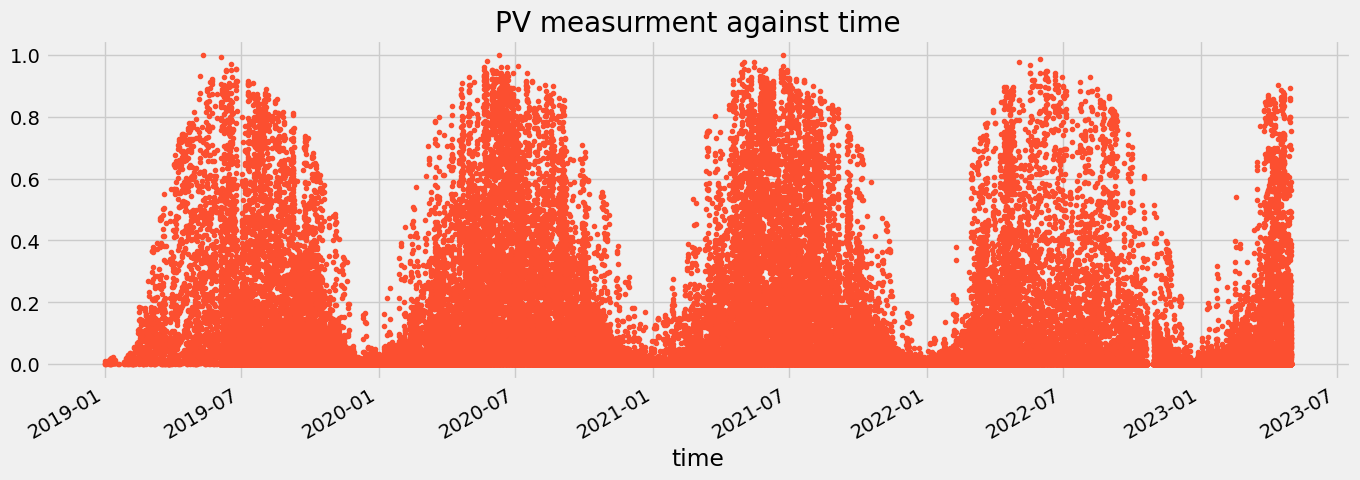

In [109]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Choosing Lag Variables

First we have to make some plots. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. These are meant to help to detrermine which features we can use as lags.

In [110]:
''' 
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for feature in  FEATURES:
    n_lags = 72 
    # ACF plot
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plot_acf(df[feature], lags=n_lags, ax=plt.gca(), alpha=0.05)  # alpha=0.05 for 95% CI
    plt.title('Autocorrelation Function: ' + feature, fontsize = 12)
    plt.grid(True)
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')

    # PACF plot
    plt.subplot(1, 2, 2)
    plot_pacf(df[feature], lags=n_lags, ax=plt.gca(), alpha=0.05)
    plt.title('Partial Autocorrelation Function: ' + feature, fontsize=12)
    plt.grid(True)
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')

    plt.tight_layout()
    plt.show()
'''


" \nimport matplotlib.pyplot as plt\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\n\nfor feature in  FEATURES:\n    n_lags = 72 \n    # ACF plot\n    plt.figure(figsize=(14, 5))\n    plt.subplot(1, 2, 1)\n    plot_acf(df[feature], lags=n_lags, ax=plt.gca(), alpha=0.05)  # alpha=0.05 for 95% CI\n    plt.title('Autocorrelation Function: ' + feature, fontsize = 12)\n    plt.grid(True)\n    plt.xlabel('Lag')\n    plt.ylabel('Autocorrelation')\n\n    # PACF plot\n    plt.subplot(1, 2, 2)\n    plot_pacf(df[feature], lags=n_lags, ax=plt.gca(), alpha=0.05)\n    plt.title('Partial Autocorrelation Function: ' + feature, fontsize=12)\n    plt.grid(True)\n    plt.xlabel('Lag')\n    plt.ylabel('Partial Autocorrelation')\n\n    plt.tight_layout()\n    plt.show()\n"

### Now Adding the Lag Variables to the dataset

In [111]:

def create_lags(df, column, lags):
    for lag in lags:
        name = f"{column}_lag_{lag}"
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)
        if name not in FEATURES:
            FEATURES.append(name)
    return df

lag_definitions = {
    "is_day:idx": [1, 24, 48],
    "clear_sky_rad:W": [1, 24],
    "is_in_shadow:idx": [1, 24, 48],
    "sun_azimuth:d": [1, 24],
    #"pv_measurement": [1, 24]
}

for column, lags in lag_definitions.items():
    df = create_lags(df, column, lags)

df.head()

,direct_rad_1h:J,effective_cloud_cover:p,clear_sky_energy_1h:J,visibility:m,sun_elevation:d,is_day:idx,clear_sky_rad:W,is_in_shadow:idx,sun_azimuth:d,hour,...,is_day:idx_lag_1,is_day:idx_lag_24,is_day:idx_lag_48,clear_sky_rad:W_lag_1,clear_sky_rad:W_lag_24,is_in_shadow:idx_lag_1,is_in_shadow:idx_lag_24,is_in_shadow:idx_lag_48,sun_azimuth:d_lag_1,sun_azimuth:d_lag_24
time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 10:00:00,140.500000,399.400024,178143.09375,15510.099609,10.716,4.0,81.300003,0.0,665.742981,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 11:00:00,313.600006,396.299988,357289.31250,52637.398438,13.821,4.0,108.300003,0.0,721.046021,11,...,4.0,NaN,NaN,81.300003,NaN,0.0,NaN,NaN,665.742981,NaN
2019-01-01 12:00:00,1356.000000,385.399994,353490.90625,83163.398438,10.473,4.0,79.400002,0.0,776.333984,12,...,4.0,NaN,NaN,108.300003,NaN,0.0,NaN,NaN,721.046021,NaN
2019-01-01 13:00:00,1183.000000,382.200012,170034.50000,47947.199219,0.910,2.0,14.900000,4.0,830.840027,13,...,4.0,NaN,NaN,79.400002,NaN,0.0,NaN,NaN,776.333984,NaN
2019-01-02 10:00:00,264.100006,400.000000,185088.09375,63841.699219,10.994,4.0,83.699997,0.0,665.275024,10,...,2.0,NaN,NaN,14.900000,NaN,4.0,NaN,NaN,830.840027,NaN


We have NaN values after the insertion of the lag variables. We must fill them somehow..

In [112]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

direct_rad_1h:J             0
effective_cloud_cover:p     0
clear_sky_energy_1h:J       0
visibility:m                0
sun_elevation:d             0
is_day:idx                  0
clear_sky_rad:W             0
is_in_shadow:idx            0
sun_azimuth:d               0
hour                        0
dayofweek                   0
quarter                     0
month                       0
year                        0
dayofyear                   0
dayofmonth                  0
weekofyear                  0
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
is_day:idx_lag_1            1
is_day:idx_lag_24          24
is_day:idx_lag_48          48
clear_sky_rad:W_lag_1       1
clear_sky_rad:W_lag_24     24
is_in_shadow:idx_lag_1      1
is_in_shadow:idx_lag_24    24
is_in_shadow:idx_lag_48    48
sun_azimuth:d_lag_1         1
sun_azimuth:d_lag_24       24
dtype: int64
direct_rad_1h:J            

In [113]:
df = df.dropna()

In [114]:
X_train_estimated_a.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,estimated
date_forecast,,,,,,,,,,,,,,,,,,,,,
2022-10-28 22:00:00,33.400002,4.932,9665.000000,0.0,0.0,6939.799805,4.0,1125.099976,0.0,0.0,...,0.0,1138.700073,400.0,82850.101562,2.800000,-1.3,2.6,0.0,A,1
2022-10-28 23:00:00,32.400002,4.936,16140.799805,0.0,0.0,8239.500000,4.0,1123.400024,0.0,0.0,...,0.0,1137.300049,400.0,22496.699219,3.100000,1.7,2.1,0.0,A,1
2022-10-29 00:00:00,32.599998,4.919,7528.000000,0.0,0.0,6700.200195,4.0,1123.699951,0.0,0.0,...,0.8,1135.500000,400.0,12961.700195,6.000000,4.2,3.9,0.0,A,1
2022-10-29 01:00:00,32.799999,4.914,6489.600098,0.0,0.0,6190.200195,4.0,1124.199951,0.0,0.0,...,1.0,1137.400024,400.0,12974.000000,6.300000,4.0,4.8,0.0,A,1
2022-10-29 02:00:00,33.500000,4.908,5289.100098,0.0,0.0,4214.899902,4.0,1125.399902,0.0,0.0,...,1.0,1138.099976,400.0,10113.799805,8.799999,7.3,4.7,0.0,A,1


In [115]:
X_train_estimated_b.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,estimated
date_forecast,,,,,,,,,,,,,,,,,,,,,
2022-10-28 22:00:00,33.599998,4.930,9665.799805,0.0,0.0,6951.200195,4.0,1125.800049,0.0,0.0,...,0.0,1138.700073,400.0,82755.398438,2.800000,-1.3,2.5,0.0,B,1
2022-10-28 23:00:00,33.400002,4.928,16141.000000,0.0,0.0,8259.200195,4.0,1124.900024,0.0,0.0,...,0.0,1137.300049,400.0,22485.699219,3.100000,1.7,2.1,0.0,B,1
2022-10-29 00:00:00,32.400002,4.916,7523.500000,0.0,0.0,6694.399902,4.0,1123.599976,0.0,0.0,...,0.8,1135.500000,400.0,13086.500000,6.000000,4.2,3.8,0.0,B,1
2022-10-29 01:00:00,32.799999,4.913,6490.399902,0.0,0.0,6190.299805,4.0,1124.199951,0.0,0.0,...,1.0,1137.400024,400.0,12978.400391,6.300000,4.0,4.8,0.0,B,1
2022-10-29 02:00:00,33.500000,4.907,5288.899902,0.0,0.0,4215.299805,4.0,1125.399902,0.0,0.0,...,1.0,1138.099976,400.0,10118.400391,8.799999,7.4,4.6,0.0,B,1


In [116]:
X_train_estimated_c.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,estimated
date_forecast,,,,,,,,,,,,,,,,,,,,,
2022-10-28 22:00:00,33.099998,4.923,9679.000000,0.0,0.0,6124.000000,4.0,1124.600098,0.0,0.0,...,0.0,1140.400024,400.0,95972.500000,4.8,-0.6,4.7,0.0,C,1
2022-10-28 23:00:00,32.200001,4.924,16317.000000,0.0,0.0,6761.600098,4.0,1123.199951,0.0,0.0,...,0.0,1138.800049,400.0,24432.199219,4.8,2.1,4.1,0.0,C,1
2022-10-29 00:00:00,32.400002,4.910,8080.000000,0.0,0.0,7087.000000,4.0,1123.399902,0.0,0.0,...,0.9,1136.900024,400.0,13414.700195,8.2,5.2,6.3,0.0,C,1
2022-10-29 01:00:00,32.900002,4.903,6491.200195,0.0,0.0,6206.799805,4.0,1124.199951,0.0,0.0,...,1.0,1139.000000,400.0,13668.299805,7.6,3.8,6.4,0.0,C,1
2022-10-29 02:00:00,33.799999,4.894,5397.399902,0.0,0.0,4173.700195,4.0,1125.800049,0.0,0.0,...,0.9,1139.099976,400.0,10506.799805,9.2,6.6,6.2,0.0,C,1


### An issue when we add lag variables in our test set

In our test we will aquiere some NaN values in the lag variables. We can fix this by using the values from the estimated training sets to fill in for these lag values. 

To account for this we need to fix the X_train_estimated for the datasets (aggregating, adding column so on..).

In [117]:
# Fixing for A
X_train_estimated_a.drop('location', axis=1, inplace=True)
X_train_estimated_a = create_features(X_train_estimated_a)
# location A already has an "estimated" column

# Fixing for B
X_train_estimated_b.drop('location', axis=1, inplace=True)
X_train_estimated_b = create_features(X_train_estimated_b)

# Fixing for C
X_train_estimated_c.drop('location', axis=1, inplace=True)
X_train_estimated_c = create_features(X_train_estimated_c)

X_train_estimated_b.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_w_1000hPa:ms,estimated,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date_forecast,,,,,,,,,,,,,,,,,,,,,
2022-10-28 22:00:00,33.599998,4.930,9665.799805,0.0,0.0,6951.200195,4.0,1125.800049,0.0,0.0,...,0.0,1,22,4,4,10,2022,301,28,43
2022-10-28 23:00:00,33.400002,4.928,16141.000000,0.0,0.0,8259.200195,4.0,1124.900024,0.0,0.0,...,0.0,1,23,4,4,10,2022,301,28,43
2022-10-29 00:00:00,32.400002,4.916,7523.500000,0.0,0.0,6694.399902,4.0,1123.599976,0.0,0.0,...,0.0,1,0,5,4,10,2022,302,29,43
2022-10-29 01:00:00,32.799999,4.913,6490.399902,0.0,0.0,6190.299805,4.0,1124.199951,0.0,0.0,...,0.0,1,1,5,4,10,2022,302,29,43
2022-10-29 02:00:00,33.500000,4.907,5288.899902,0.0,0.0,4215.299805,4.0,1125.399902,0.0,0.0,...,0.0,1,2,5,4,10,2022,302,29,43


In [118]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)

    x_test = drop_data(x_test)
    x_test = add_missing_dates(x_test)
    x_test = impute_missing_data(x_test)

    # Might change order of this
    x_test = x_test.resample('60min').sum()
    
    cap_date = x_test.index.min()

    x_test = create_features(x_test)
    x_test['estimated'] = 1

    if location == 'A':
        x_test['location_A'], X_train_estimated_a['location_A'] = 1, 1
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0

        x_test = concat_and_lagify(x_test, X_train_estimated_a)
    elif location == 'B':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 1, 1
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0

        x_test = concat_and_lagify(x_test, X_train_estimated_b)
    elif location == 'C':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 1, 1

        x_test = concat_and_lagify(x_test, X_train_estimated_c)

    x_test = x_test.loc[cap_date:]
    return x_test

def create_lag_variables(x):
    lag_definitions = {
        "is_day:idx": [1, 24, 48],
        "clear_sky_rad:W": [1, 24],
        "is_in_shadow:idx": [1, 24, 48],
        "sun_azimuth:d": [1, 24],
    }

    for column, lags in lag_definitions.items():
        x = create_lags(x, column, lags)
    return x

def concat_and_lagify(df1, df2):
    df1 = pd.concat([df1, df2], ignore_index=False)
    df1 = df1.sort_index()
    df1 = create_lag_variables(df1)
    df1 = df1[FEATURES]
    return df1

def add_missing_dates(df):
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    df = pd.concat([df, missing_df]).sort_index()
    return df

def impute_missing_data(df):
    df = df.astype('float64')

    original_index = df.index

    imputer = IterativeImputer(random_state=42)
    imputed = imputer.fit_transform(df)
    df = pd.DataFrame(imputed, columns=df.columns, index=original_index)
    return df

def drop_data(df):
    df.drop(['ceiling_height_agl:m', 'cloud_base_agl:m', 
                             'snow_density:kgm3', 'date_calc'], axis=1, inplace=True)
    return df

In [119]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

Excluding unvalid dates

<Axes: >

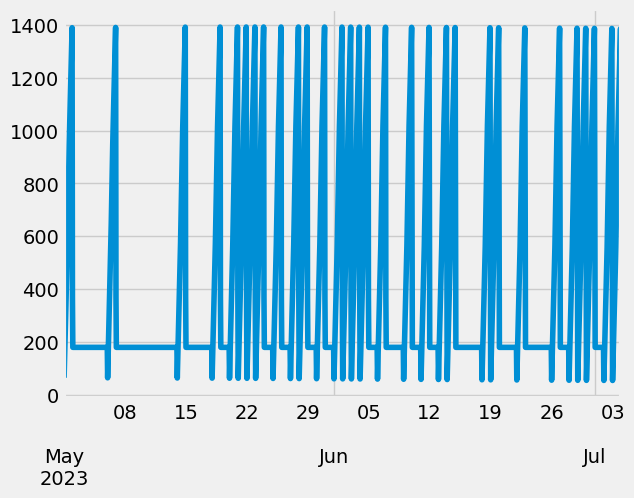

In [120]:
test_sub = pd.read_csv('../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())
x_test_a['sun_azimuth:d'].plot()

In [121]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_a.loc[valid_dates]
x_test_c = x_test_a.loc[valid_dates]

Now concatonating the test date to create on X_test

In [122]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])

In [123]:
X_test.loc['2023-05-01 00:00:00']

,direct_rad_1h:J,effective_cloud_cover:p,clear_sky_energy_1h:J,visibility:m,sun_elevation:d,is_day:idx,clear_sky_rad:W,is_in_shadow:idx,sun_azimuth:d,hour,...,is_day:idx_lag_1,is_day:idx_lag_24,is_day:idx_lag_48,clear_sky_rad:W_lag_1,clear_sky_rad:W_lag_24,is_in_shadow:idx_lag_1,is_in_shadow:idx_lag_24,is_in_shadow:idx_lag_48,sun_azimuth:d_lag_1,sun_azimuth:d_lag_24
2023-05-01,0.0,299.799995,0.0,119629.998047,-42.164,0.0,0.0,4.0,64.106,0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,368.838013,64.139999
2023-05-01,0.0,299.799995,0.0,119629.998047,-42.164,0.0,0.0,4.0,64.106,0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,368.838013,64.139999
2023-05-01,0.0,299.799995,0.0,119629.998047,-42.164,0.0,0.0,4.0,64.106,0,...,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,368.838013,64.139999


In [124]:
q = df.copy()
q = q[FEATURES]
q.columns

Index(['direct_rad_1h:J', 'effective_cloud_cover:p', 'clear_sky_energy_1h:J',
       'visibility:m', 'sun_elevation:d', 'is_day:idx', 'clear_sky_rad:W',
       'is_in_shadow:idx', 'sun_azimuth:d', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'location_A',
       'location_B', 'location_C', 'estimated', 'is_day:idx_lag_1',
       'is_day:idx_lag_24', 'is_day:idx_lag_48', 'clear_sky_rad:W_lag_1',
       'clear_sky_rad:W_lag_24', 'is_in_shadow:idx_lag_1',
       'is_in_shadow:idx_lag_24', 'is_in_shadow:idx_lag_48',
       'sun_azimuth:d_lag_1', 'sun_azimuth:d_lag_24'],
      dtype='object')

### Disability Check

Check if the training data and the test data contains the same columns.

In [125]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [126]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


In [127]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}

X_train = df[FEATURES]
y_train = df[TARGET]

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.3s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.4s
[CV] END colsample_bytree=0

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 6, 5, 10],
                         'n_estimators': [100, 300, 500, 700, 900, 1000]},
             verbose=2)

### Now Saving the Model!

In [128]:
import joblib

joblib.dump(grid_search, 'xgboost_model.pkl')

['xgboost_model.pkl']

In [129]:
predictions = grid_search.predict(X_test)

In [130]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

n = len(predictions)

# De-normalizing
predictions.loc[:n//3, 'prediction'] = scaler_a.inverse_transform(predictions.loc[:n//3, 'prediction'].values.reshape(-1, 1))[:, 0]
predictions.loc[n//3:2*n//3, 'prediction'] = scaler_b.inverse_transform(predictions.loc[n//3:2*n//3, 'prediction'].values.reshape(-1, 1))[:, 0]
predictions.loc[2*n//3:, 'prediction'] = scaler_c.inverse_transform(predictions.loc[2*n//3:, 'prediction'].values.reshape(-1, 1))[:, 0]


predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

Remove negative values

In [131]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

# IF NECCESARY CREATE A VISUAL PLOT OF PREDICTION

lag variables

Rolling Window Statistics

## What happened?

It underestimated for location A.
Provided ok/mediocre results for location B and C.

It is possible that only data from A must be used to predict for location A

There is a gap in time in the features of B and C. This has not been acounted for.

Also pv_measurments is accumulated produced energy over an hour. Mabye we must aggregate weather data instead of taking the mean